In [1]:
pip install --upgrade pip

  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install yfinance


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install pennylane


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Choose some assets (e.g., 5 big tech stocks)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
data = yf.download(tickers, start='2024-01-01', end='2025-01-01')
# Extract 'Adj Close' from multi-index columns
data = data['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [6]:
data.shape

(252, 5)

In [7]:
# Compute daily returns
returns = data.pct_change().dropna()
returns.shape

(251, 5)

In [8]:
# Compute expected returns and covariance matrix
expected_returns = returns.mean().values     # average daily return for each asset
cov_matrix = returns.cov().values        # risk (covariance)

In [9]:
R = expected_returns  # shape: (n,)
Sigma = cov_matrix    # shape: (n, n)

In [10]:
R.shape,Sigma.shape

((5,), (5, 5))

In [11]:
lambda_risk = 0.5
alpha = 500
k= 3
t = (R.shape[0]/2)-k

In [12]:
from pennylane import Hamiltonian, PauliZ

coeffs = []
ops = []

# Return term: -Rᵢ xᵢ

for i in range(R.shape[0]):
    #constant term
    coeff = -R[i] * 0.5
    coeffs.append(coeff)
    ops.append(qml.Identity(0))
    
    #Single qubit term
    coeffs.append(-coeff)
    ops.append(PauliZ(i))

# Risk term: λ Σᵢⱼ xᵢ xⱼ

for i in range(R.shape[0]):
    for j in range(R.shape[0]):
        coeff = lambda_risk * Sigma[i][j] * 0.25
        
        if i == j:
            #Constant term
            coeffs.append(coeff)
            ops.append(qml.Identity(0))
            #Constant
            coeffs.append(coeff)
            ops.append(qml.Identity(i)) 
            #Single qubit term
            coeffs.append(-2*coeff)
            ops.append(PauliZ(i))

        else:
            # interaction term
            coeffs.append(coeff)
            ops.append(PauliZ(i) @ PauliZ(j))

            #single qubit terms
            coeffs.append(-coeff)
            ops.append(PauliZ(i))
            coeffs.append(-coeff)
            ops.append(PauliZ(j))

            # Add constant term (optional)
            coeffs.append(coeff)
            ops.append(qml.Identity(0))

#Penalty term: Pick exactly k=3 out of 5 assets

#Constant term
coeff_penal = alpha
coeffs.append(coeff_penal*(t**2))
ops.append(qml.Identity(0))

for i in range(R.shape[0]):
    #terms -alpha*tΣᵢZi
    coeffs.append(-alpha*t)
    ops.append(qml.PauliZ(i))
    
    #terms alpha*0.25ΣᵢZi^2
    coeffs.append(alpha*0.25)
    ops.append(qml.Identity(i))

    for j in range(i+1,R.shape[0]):
    #terms alpha*0.25ΣijZiZj
        coeffs.append(alpha*0.25)
        ops.append(qml.PauliZ(i)@qml.PauliZ(j))

#Penalty_term: Only invest in at most 1 assets from Tech sector
#to be added later

cost_h = qml.Hamiltonian(coeffs, ops)


In [13]:
#QAOA for p=10
dev = qml.device("default.qubit", wires=R.shape[0])
def apply_cost(gamma):
    for term, coeff in zip(ops, coeffs):
        qml.ApproxTimeEvolution(coeff * term, gamma, 1)

def apply_mixer(beta):
    for i in range(R.shape[0]):
        qml.RX(-2 * beta, wires=i)

@qml.qnode(dev)
def qaoa(params,p):
    gamma, beta = params[:p], params[p:]
    
    # Start in uniform superposition
    for i in range(R.shape[0]):
        qml.Hadamard(wires=i)
    for k in range(p):
        apply_cost(gamma[k])
        apply_mixer(beta[k])
    
    return qml.expval(cost_h)

In [25]:
from pennylane.optimize import GradientDescentOptimizer

gamma = np.random.uniform(0, np.pi, size=10)
beta = np.random.uniform(0, np.pi, size=10)

params = np.concatenate([gamma, beta])
params = np.array(params,requires_grad=True)

#params = np.array([0.5, 0.5], requires_grad=True)
opt = GradientDescentOptimizer(stepsize=0.01)

for i in range(100):
    params = opt.step(qaoa, params,p=10)
    if i % 5 == 0:
        print(f"Step {i}: Cost = {qaoa(params,p=10):.4f}")
print("Final parameters:", params)
print("Final cost:", qaoa(params,p=10))


Step 0: Cost = 798.9892
Step 5: Cost = 818.5207
Step 10: Cost = 589.7811
Step 15: Cost = 768.0997
Step 20: Cost = 751.9243
Step 25: Cost = 753.5648
Step 30: Cost = 596.7233
Step 35: Cost = 631.8272
Step 40: Cost = 892.6371
Step 45: Cost = 879.1446
Step 50: Cost = 672.0607
Step 55: Cost = 809.7867
Step 60: Cost = 732.6059
Step 65: Cost = 774.6276
Step 70: Cost = 743.3480
Step 75: Cost = 578.5434
Step 80: Cost = 590.8643
Step 85: Cost = 802.4967
Step 90: Cost = 575.9643
Step 95: Cost = 740.2122
Final parameters: [ 1.02122714e+04  1.10544425e+02  1.75727438e+04 -1.07678271e+04
  5.89085526e+03 -2.12823108e+04  1.29349075e+04  2.16670999e+03
 -1.52305359e+04 -1.77202762e+04  3.01050653e+01  7.13110987e+01
  6.91549013e+01  2.89447214e+01 -6.04255515e+01 -1.23766456e+01
 -1.91370572e+01 -1.18604117e+01  5.96153449e+00  3.24920073e+01]
Final cost: 744.4041768055376


In [26]:
#Updating the QAOA to collect sample
@qml.qnode(dev)
def qaoa_sample(params,p):
    gamma, beta = params[:p], params[p:]
    
    # Start in uniform superposition
    for i in range(R.shape[0]):
        qml.Hadamard(wires=i)
    for k in range(p):
        apply_cost(gamma[k])
        apply_mixer(beta[k])
    
    return qml.sample()

In [27]:
dev = qml.device("default.qubit", wires=R.shape[0], shots=1000)

In [28]:
qaoa_sample(params,p=10)

array([[0, 1, 0, 1, 0],
       [1, 1, 1, 0, 1],
       [1, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [0, 1, 1, 1, 1]], shape=(1000, 5))

In [29]:
#To collect and analyze samples
from collections import Counter

samples = qaoa_sample(params,p=5)  # shape: (shots, n_assets)

# Convert each bitstring to a tuple
bitstrings = [tuple(sample) for sample in samples]

# Count frequencies
counts = Counter(bitstrings)
most_common = counts.most_common(1)[0]
most_common[0]

(np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0))

In [30]:
best_portfolio = most_common[0]
best_portfolio_1 = tuple(int(x) for x in best_portfolio)

frequency = most_common[1] / 1000

print("Most probable portfolio:", best_portfolio_1)
print("Probability:", frequency)

Most probable portfolio: (0, 0, 0, 0, 0)
Probability: 0.169


In [31]:
def plot_portfolio_distribution(counts, shots):
    labels = [''.join(map(str, b)) for b in counts.keys()]
    values = [v / shots for v in counts.values()]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel("Portfolio (bitstring)", fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.title("QAOA Portfolio Distribution", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

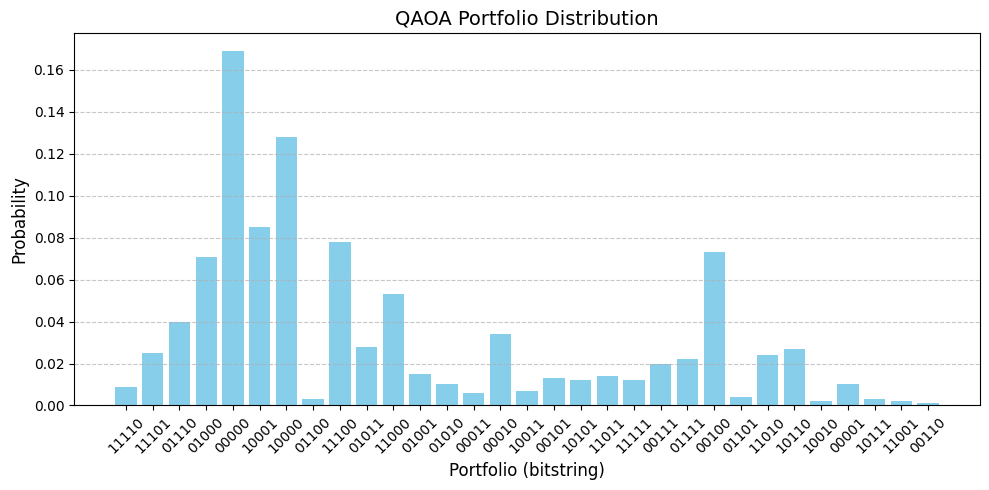

In [32]:
plot_portfolio_distribution(counts, 1000)